<a href="https://colab.research.google.com/github/Suhit97/Table-Detection-and-Extraction/blob/main/Detection_cropping_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytesseract

In [ ]:
!sudo apt install tesseract-ocr

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly&response_type=code

Enter your authorization code:
4/1AY0e-g66S7_eUyVsPdrRVeI7g1xp7ehoYfrVTvcvW7Hc4eSmvHFPy4Yk8sA
Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/MyDrive/table_detection

/content/gdrive/MyDrive/table_detection


In [ ]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

In [ ]:
import matplotlib
import matplotlib.pyplot as plt


import tensorflow as tf
import os
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import cv2
import pandas as pd
import csv

try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract




from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

In [ ]:
def load_image_into_numpy_array(path):
  
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)




In [ ]:
model = tf.saved_model.load(f'inference_graph/saved_model')

In [ ]:
def run_inference_for_single_image(model, image):
  image = np.asarray(image)
  # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
  input_tensor = tf.convert_to_tensor(image)
  # The model expects a batch of images, so add an axis with `tf.newaxis`.
  input_tensor = input_tensor[tf.newaxis,...]

  # Run inference
  model_fn = model.signatures['serving_default']
  output_dict = model_fn(input_tensor)

  # All outputs are batches tensors.
  # Convert to numpy arrays, and take index [0] to remove the batch dimension.
  # We're only interested in the first num_detections.
  num_detections = int(output_dict.pop('num_detections'))
  output_dict = {key:value[0, :num_detections].numpy() 
                 for key,value in output_dict.items()}
  output_dict['num_detections'] = num_detections

  # detection_classes should be ints.
  output_dict['detection_classes'] = output_dict['detection_classes'].astype(np.int64)
   
  # Handle models with masks:
  if 'detection_masks' in output_dict:
    # Reframe the the bbox mask to the image size.
    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              output_dict['detection_masks'], output_dict['detection_boxes'],
               image.shape[0], image.shape[1])      
    detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5,
                                       tf.uint8)
    output_dict['detection_masks_reframed'] = detection_masks_reframed.numpy()
    
  return output_dict

In [ ]:
image_path = 'test/images/cTDaR_t10148.jpg'



In [ ]:
# If its a png file

from PIL import Image

im = Image.open("table_data.png")
rgb_im = im.convert('RGB')
rgb_im.save('table_so.jpg')


In [ ]:
image_path = 'table_so.jpg'

In [ ]:
import imageio

image = imageio.imread('table_so.jpg')
print(image.shape)

(500, 1349, 3)


In [ ]:
class_id = 1


category_index = {class_id: {'id': class_id, 'name': 'table'}}

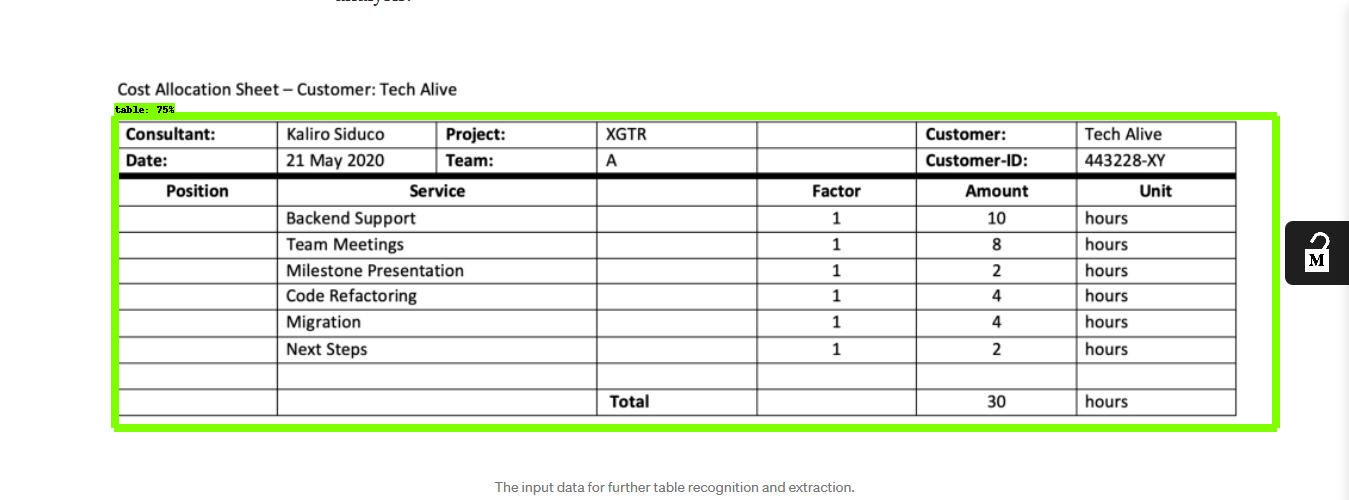

In [ ]:

image_np = load_image_into_numpy_array(image_path)
output_dict = run_inference_for_single_image(model, image_np)
viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks_reframed', None),
      use_normalized_coordinates=True,
      line_thickness=8)
display(Image.fromarray(image_np))

In [ ]:
width, height = image.shape[0], image.shape[1]

In [ ]:
print(height,width)

1349 500


In [ ]:
def get_bounding_box(
    boxes,
    scores,
    max_boxes_to_draw=20,
    min_score_thresh=.5,
    ):
  
  # Create a display string (and color) for every box location, group any boxes
  # that correspond to the same location.

  for i in range(min(max_boxes_to_draw, boxes.shape[0])):
   if scores is None or scores[i] > min_score_thresh:
      box = tuple(boxes[i].tolist())

  im_height, im_width = image.shape[:2]

  ymin, xmin, ymax, xmax = box

  #left, right, top, bottom) = (xmin * im_width, xmax * im_width, ymin * im_height, ymax * im_height)
  #ymin, xmin, ymax - ymax, xmax - xmin
  #yminn = ymin*im_height
  #ymaxx = ymax*im_height
  #xminn = xmin* im_width
  #xmaxx = xmax* im_width
  
  #return (ymin*im_height, xmin* im_width,  ymax*im_height - ymin*im_height, xmax* im_width - xmin* im_width)
  #return ( xmin* im_width, ymin*im_height, xmax* im_width - xmin* im_width, ymax*im_height - ymin*im_height)
  return ( xmin* im_width, ymin*im_height, xmax* im_width , ymax*im_height )
  #return (ymin,xmin,xmax - xmin,ymax-ymin)

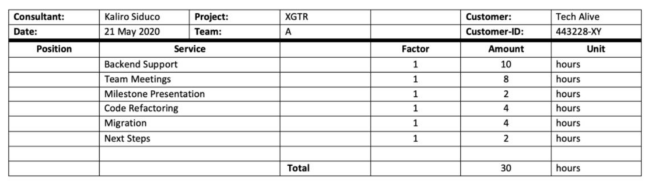

In [ ]:
plt.figure(figsize=(40,50))
from PIL import Image
bbox = get_bounding_box(output_dict['detection_boxes'],
                                  output_dict['detection_scores'])

#bbox = map(lambda x: x * 1000, bbox)

im = Image.open(image_path)
im = im.crop(bbox)
    
plt.subplot(3,3,2)
plt.axis("off")
plt.imshow(im)    

    

In [ ]:
im = im.save("crop1.jpg")


In [ ]:
file=r'crop1.jpg'
img = cv2.imread(file,0)
img.shape

(311, 1162)

In [ ]:
sample=r'crop.jpg'
read_image= cv2.imread(sample,0)
read_image.shape

(443, 503)

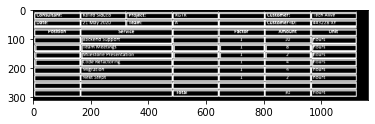

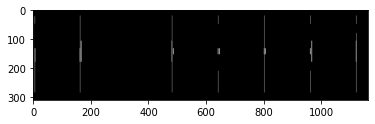

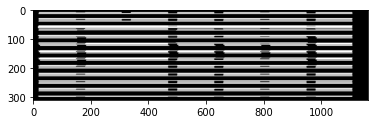

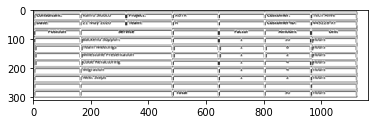

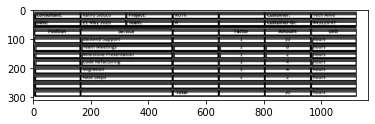

[[965, 283, 156, 13], [805, 283, 157, 13], [645, 283, 157, 13], [485, 283, 157, 13], [166, 283, 316, 13], [9, 283, 154, 13], [5, 283, 1, 13]]
[[[965, 16, 156, 12], [805, 16, 157, 12], [645, 16, 157, 12], [485, 16, 157, 12], [166, 16, 316, 12], [9, 16, 154, 12], [5, 16, 1, 12]], [[965, 42, 156, 11], [805, 42, 157, 11], [645, 42, 157, 11], [485, 42, 157, 11], [166, 42, 316, 11], [9, 42, 154, 11], [5, 42, 1, 11]], [[166, 72, 316, 14], [805, 73, 316, 13], [485, 73, 317, 13], [5, 73, 158, 13]], [[970, 100, 150, 13], [805, 100, 161, 12], [485, 100, 317, 12], [170, 100, 311, 13], [5, 100, 158, 12]], [[5, 122, 1, 18], [970, 126, 150, 13], [965, 126, 1, 13], [809, 126, 152, 13], [650, 126, 151, 13], [645, 126, 1, 13], [490, 126, 151, 13], [485, 126, 1, 13], [170, 126, 311, 13], [10, 126, 152, 13]], [[5, 148, 1, 17], [970, 152, 150, 12], [965, 152, 1, 12], [809, 152, 152, 12], [650, 152, 151, 12], [645, 152, 1, 12], [490, 152, 151, 12], [485, 152, 1, 12], [170, 152, 311, 12], [10, 152, 152, 12]]

,0,1,2,3,4,5,6
0,,LOnNSUIant.\n,| Saure aaucu q rryjyece.\n,pAyrin\n,,| -ustomer.\n,pice aAnve\n
1,,,[| 44 Iviay 2UuzU I] 'eam:\n,,,| ustomenr mw:\n,[445220°AT\n
2,rusien\n,,oervice\n,rac\n,,AMmUUTIL ll vn\n,
3,,,joecKhena Support\n,,,4u\n\n \n,prour >\n
4,,,l fealll VICCUNnES\n,,,,pfreurs\n
5,,,Jwinestone rresentauon\n,,,,pfrours\n
6,,,[Loge neractoring\n,,,\n,frour s\n
7,,,l wigrauen\n,,,,\n
8,,,| NEAL Steps\n,,,,\n
9,,,,,,,


In [ ]:
thresh,img_bin = cv2.threshold(img,128,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)

#inverting the image 
img_bin = 255-img_bin
#Plotting the image to see the output
plotting = plt.imshow(img_bin,cmap='gray')
plt.show()

# countcol(width) of kernel as 100th of total width
kernel_len = np.array(img).shape[1]//100
# Defining a vertical kernel to detect all vertical lines of image 
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
# Defining a horizontal kernel to detect all horizontal lines of image
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))
# A kernel of 2x2
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

#Use vertical kernel to detect and save the vertical lines in a jpg
image_1 = cv2.erode(img_bin, ver_kernel, iterations=3)
vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=3)

#Plot the generated image
plotting = plt.imshow(image_1,cmap='gray')
plt.show()

#Use horizontal kernel to detect and save the horizontal lines in a jpg
image_2 = cv2.erode(img_bin, hor_kernel, iterations=3)
horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=3)
#Plot the generated image
plotting = plt.imshow(image_2,cmap='gray')
plt.show()

# Combine horizontal and vertical lines in a new third image, with both having same weight.
img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
#Eroding and thesholding the image
img_vh = cv2.erode(~img_vh, kernel, iterations=2)
thresh, img_vh = cv2.threshold(img_vh,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
bitxor = cv2.bitwise_xor(img,img_vh)
bitnot = cv2.bitwise_not(bitxor)
#Plotting the generated image
plotting = plt.imshow(bitnot,cmap='gray')
plt.show()

# Detect contours for following box detection
contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0
    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

# Sort all the contours by top to bottom.
contours, boundingBoxes = sort_contours(contours, method="top-to-bottom")

#Creating a list of heights for all detected boxes
heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]

#Get mean of heights
mean = np.mean(heights)

#Create list box to store all boxes in  
box = []
# Get position (x,y), width and height for every contour and show the contour on image
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if (w<1000 and h<500):
        image = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        box.append([x,y,w,h])
        
plotting = plt.imshow(image,cmap='gray')
plt.show()

#Creating two lists to define row and column in which cell is located
row=[]
column=[]
j=0

#Sorting the boxes to their respective row and column
for i in range(len(box)):    
        
    if(i==0):
        column.append(box[i])
        previous=box[i]    
    
    else:
        if(box[i][1]<=previous[1]+mean/2):
            column.append(box[i])
            previous=box[i]            
            
            if(i==len(box)-1):
                row.append(column)        
            
        else:
            row.append(column)
            column=[]
            previous = box[i]
            column.append(box[i])
            
print(column)
print(row)

#calculating maximum number of cells
countcol = 0
for i in range(len(row)):
    countcol = len(row[i])
    if countcol > countcol:
        countcol = countcol

#Retrieving the center of each column
center = [int(row[i][j][0]+row[i][j][2]/2) for j in range(len(row[i])) if row[0]]

center=np.array(center)
center.sort()
print(center)
#Regarding the distance to the columns center, the boxes are arranged in respective order

finalboxes = []
for i in range(len(row)):
    lis=[]
    for k in range(countcol):
        lis.append([])
    for j in range(len(row[i])):
        diff = abs(center-(row[i][j][0]+row[i][j][2]/4))
        minimum = min(diff)
        indexing = list(diff).index(minimum)
        lis[indexing].append(row[i][j])
    finalboxes.append(lis)


#from every single image-based cell/box the strings are extracted via pytesseract and stored in a list
outer=[]
for i in range(len(finalboxes)):
    for j in range(len(finalboxes[i])):
        inner=''
        if(len(finalboxes[i][j])==0):
            outer.append(' ')
        else:
            for k in range(len(finalboxes[i][j])):
                y,x,w,h = finalboxes[i][j][k][0],finalboxes[i][j][k][1], finalboxes[i][j][k][2],finalboxes[i][j][k][3]
                finalimg = bitnot[x:x+h, y:y+w]
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                border = cv2.copyMakeBorder(finalimg,2,2,2,2, cv2.BORDER_CONSTANT,value=[255,255])
                resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                dilation = cv2.dilate(resizing, kernel,iterations=1)
                erosion = cv2.erode(dilation, kernel,iterations=2)
                
                out = pytesseract.image_to_string(erosion)
                if(len(out)==0):
                    out = pytesseract.image_to_string(erosion, config='--psm 3')
                inner = inner +" "+ out
            outer.append(inner)

#Creating a dataframe of the generated OCR list
arr = np.array(outer)
dataset = pd.DataFrame(arr.reshape(len(row), countcol))
dataset.head(10)


#dataset.to_excel("output1.xlsx")


#dataframe = pd.DataFrame(arr.reshape(len(row), countcol))
#print(dataframe)
#data = dataframe.style.set_properties(align="left")
#Converting it in a excel-fi
#data.to_excel("output2.xlsx")

In [ ]:
dataset.head(10)

,0,1,2,3,4,5,6
0,| Consultant:\n,,| Kaliro Siduco |] Project:\n,[XGT\n,,| Customer:\n,[Tech Alive\n
1,| Date:\n,,| 21 May 2020 |] Team:\n,,,| Customer-ID:\n,]443228-XY\n
2,Position\n,,Service\n,Factor\n,,Amount ll Unit\n,
3,,,Backend Support\n,,,,hours\n
4,,,Team Meetings\n,,,,hours\n
5,,,Milestone Presentation\n,,,,hours\n
6,,,Code Refactoring\n,,,,hours\n
7,,,| Migration\n,,,,| hours\n
8,,,| Next Steps\n,,,,| hours\n
9,,,,,,,
